In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from typing import Literal
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# load train data
processed_dir = Path().cwd().parent / 'data' / 'processed'
train_path = processed_dir / 'pro_train.pkl'
test_path = processed_dir / 'pro_test.pkl'

In [3]:
train_df = pd.read_pickle(train_path)

In [4]:
def corr_significance(df: pd.DataFrame, y_var: str = "SalePrice"):
    """Calculate the correlation and the correlation significance of all columns in the dataframe

    Args:
        df (pd.DataFrame): training data
        y_var (str): target variable. Defaults to "SalePrice".

    Returns:
        pd.DataFrame: Correlation significance dataframe
    """
    num_cols = df.select_dtypes(include="number").columns

    def calculate_corr(col: str, i: int):
        return round(pearsonr(df[col], df[y_var])[i], 4)

    stats = [
        {
            "Variable": col,
            "correlation": calculate_corr(col, 0),
            "p-value": calculate_corr(col, 1),
            "significant": True if calculate_corr(col, 1) < 0.05 else False,
        }
        for col in num_cols
    ]
    return (
        pd.DataFrame(stats)
        .sort_values(by="correlation", ascending=False)
        .reset_index(drop=True)
    )

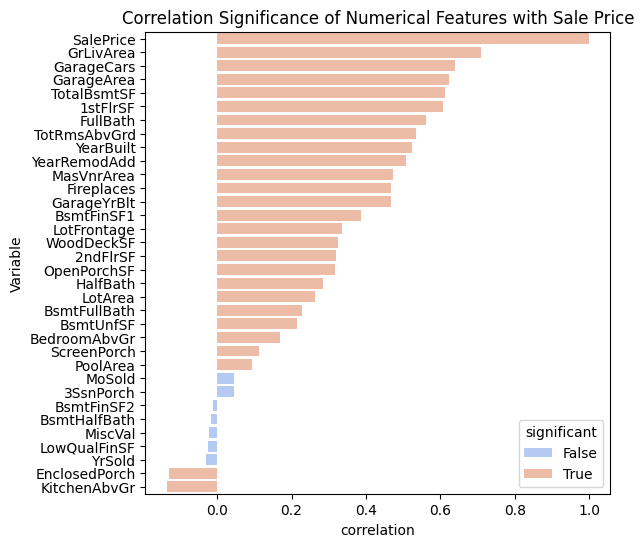

In [5]:
y_var_corr_sig = corr_significance(train_df)

plt.subplots(figsize=(6, 6))
sns.barplot(data=y_var_corr_sig, x='correlation', y='Variable', hue='significant', palette='coolwarm')
plt.title('Correlation Significance of Numerical Features with Sale Price')
plt.show()

## Mutual Information


Mutual information allows us to reduce the uncertainty of variables based on the information of other variables. If all you have available is a specific feature value, how much certainty would this give you about the value of the target variable? The mutual information score is measured on a logarithmic scale, therefore, scores over 2 are very rare given how logarithms increase slowly

In [6]:
def split_x_y_vars(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """Split the dataframe into X and y variables.

    Args:
        df (pd.DataFrame): pandas dataframe

    Returns:
        tuple[pd.DataFrame, pd.Series]: X and y variables
    """
    X = df.drop(columns='SalePrice')
    y = df['SalePrice'].copy()
    
    return X, y

In [7]:
def factorize_cats(X: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    discrete_features = X.dtypes == int
    
    return X, discrete_features

In [8]:
def create_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    X_factored, discrete_features = factorize_cats(X)
    mi_scores = mutual_info_regression(X_factored, y, discrete_features=discrete_features).round(2)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [9]:
X, y = split_x_y_vars(train_df)

mi_scores = create_mi_scores(X, y)

mi_scores.head(10)

OverallQual     0.56
Neighborhood    0.51
GarageArea      0.50
GrLivArea       0.44
YearBuilt       0.41
TotalBsmtSF     0.40
LotArea         0.39
GarageCars      0.36
KitchenQual     0.34
BsmtQual        0.32
Name: MI Scores, dtype: float64

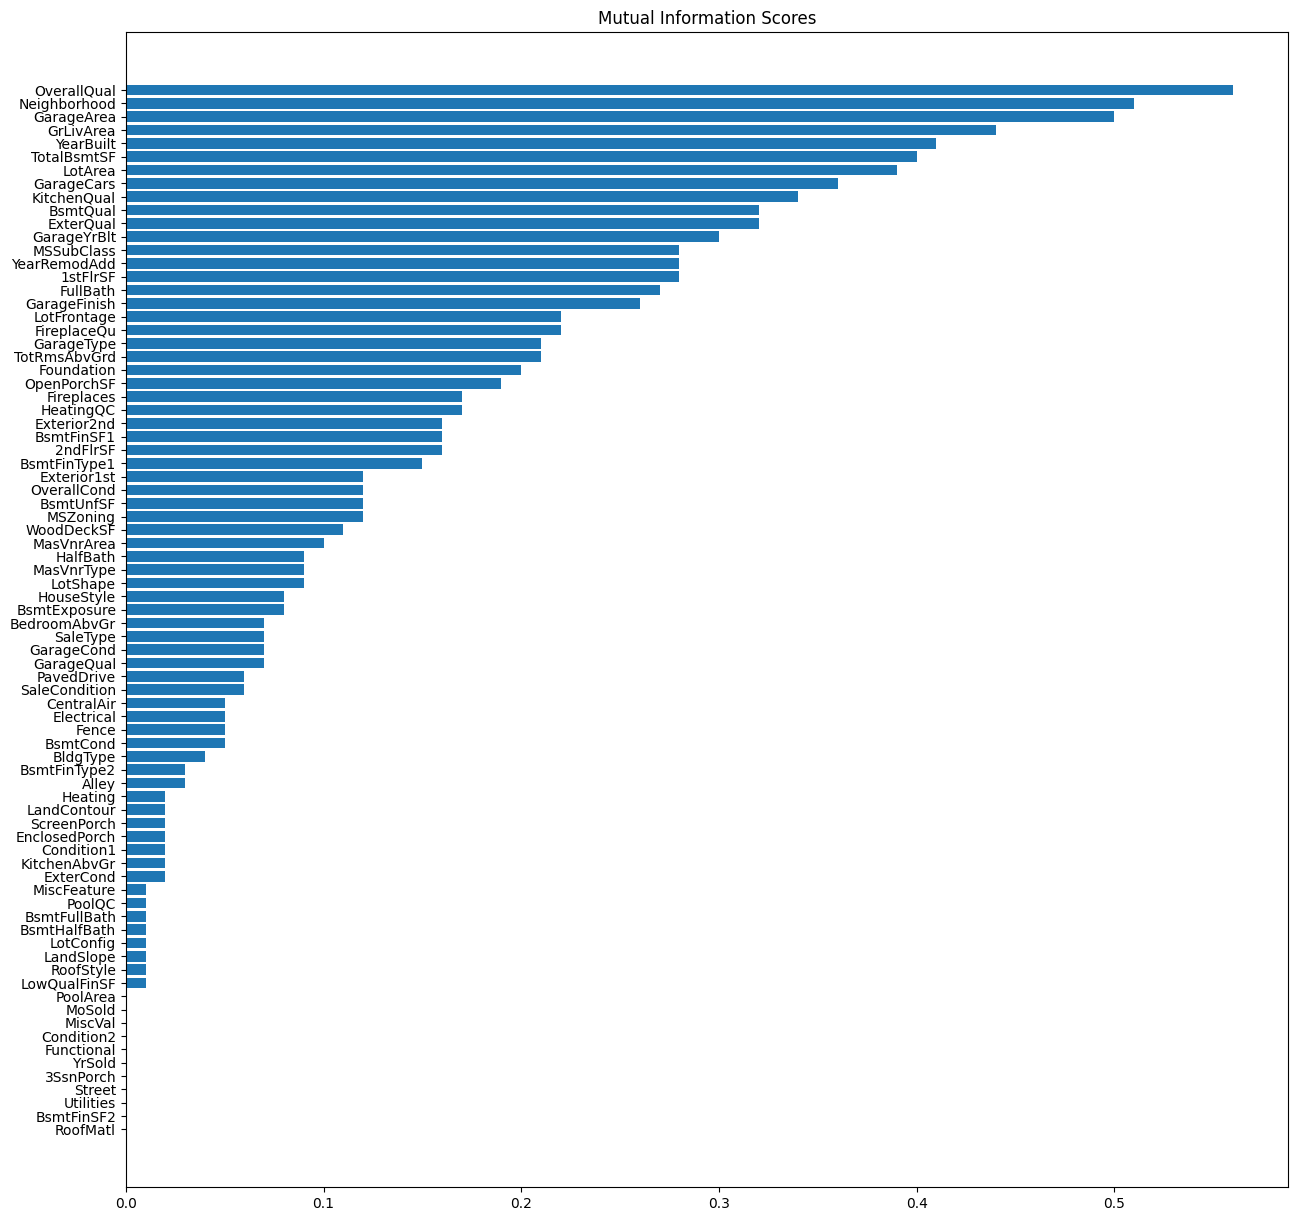

In [10]:
def plot_mi_scores(scores: pd.Series) -> None:
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(15, 15))
plot_mi_scores(mi_scores)

## Drop variables that are not significant or obtain an MI score

In [11]:
def drop_uninformative_features(
    df: pd.DataFrame, corr_sig_df: pd.DataFrame, mi_scores: pd.DataFrame
) -> pd.DataFrame:
    non_sig_vars = corr_sig_df.loc[corr_sig_df["significant"] == False][
        "Variable"
    ].values.tolist()
    zero_mi_scores = mi_scores[mi_scores == 0].index.tolist()
    cols_to_drop = list(set(non_sig_vars + zero_mi_scores))
    return df.drop(columns=cols_to_drop)

## Create Baseline to score features

In [12]:
def feature_processor(df: pd.DataFrame) -> ColumnTransformer:
    # y = 'SalePrice'
    num_cols = [col for col in df.select_dtypes(include="number").columns.tolist()]
    
    cat_cols = df.select_dtypes(include="category").columns

    # ordinal transformer
    cat_transformer = Pipeline(
        [
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
        ],
    )

    # numerical transformer
    num_transformer = Pipeline(
        [
            ("scaler", StandardScaler()),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_cols),
            ("cat", cat_transformer, cat_cols),
            # ('log', log_transfomer, y)
        ]
    )

In [13]:
def score_dataset(df: pd.DataFrame) -> float:
    X, y = split_x_y_vars(df)
    
    model = GradientBoostingRegressor(random_state=42)
    preprocessor = feature_processor(X)

    eval_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    score = -cross_val_score(eval_pipe, X, y, cv=5, scoring='neg_mean_squared_log_error').mean()
    return np.sqrt(score)

In [14]:
# Baseline model score
score_dataset(train_df)

0.13135378392944067

In [15]:
# make copy of orig data
train_df_copy = train_df.copy()

In [16]:
# drop uninformative features
train_df_copy = drop_uninformative_features(train_df_copy, y_var_corr_sig, mi_scores)

In [17]:
# score when dropping uninformative features
feature_df_1 = train_df_copy.copy()
score_dataset(feature_df_1)

0.13007163418192516

## Principle Component Analysis    

In [18]:
# what are the most correlated features?
factor_df, _ = factorize_cats(train_df_copy)
corr_df = factor_df.corr()['SalePrice'].sort_values(ascending=False).reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df.head()

,Feature,Correlation
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,ExterQual,0.682639
4,KitchenQual,0.659600


In [19]:
mi_scores = create_mi_scores(train_df_copy.drop(columns='SalePrice'), train_df_copy['SalePrice']).reset_index()
mi_scores.columns = ['Feature', 'MI Score']
mi_scores.head()

,Feature,MI Score
0,OverallQual,0.56
1,Neighborhood,0.51
2,GarageArea,0.50
3,GrLivArea,0.43
4,YearBuilt,0.41


In [20]:
corr_mi_df = pd.merge(corr_df, mi_scores, on='Feature', suffixes=('_corr', '_mi'))
corr_mi_df['combined_scores'] = corr_mi_df['Correlation'] + corr_mi_df['MI Score']
corr_mi_df.sort_values(by='combined_scores', ascending=False).head(10)

,Feature,Correlation,MI Score,combined_scores
0,OverallQual,0.790982,0.56,1.350982
1,GrLivArea,0.708624,0.43,1.138624
5,GarageArea,0.623431,0.50,1.123431
2,ExterQual,0.682639,0.34,1.022639
6,TotalBsmtSF,0.613581,0.40,1.013581
4,GarageCars,0.640409,0.37,1.010409
3,KitchenQual,0.659600,0.32,0.979600
12,YearBuilt,0.522897,0.41,0.932897
8,BsmtQual,0.585207,0.33,0.915207
7,1stFlrSF,0.605852,0.28,0.885852


In [21]:
# four features to analyse
features = [
    'TotalBsmtSF',
    'GrLivArea',
    'ExterQual',
    'GarageArea',
]

corr_mi_df[corr_mi_df['Feature'].isin(features)]

,Feature,Correlation,MI Score,combined_scores
1,GrLivArea,0.708624,0.43,1.138624
2,ExterQual,0.682639,0.34,1.022639
5,GarageArea,0.623431,0.50,1.123431
6,TotalBsmtSF,0.613581,0.40,1.013581


In [22]:
def apply_pca(
    X: pd.DataFrame, standardise: bool = True
) -> tuple[PCA, pd.DataFrame, pd.DataFrame]:
    if standardise:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(X)
    comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=comp_names, index=X.index)

    loadings = pd.DataFrame(pca.components_.T, columns=comp_names, index=X.columns)
    return pca, X_pca, loadings

In [23]:
feature_df_2 = train_df_copy.copy()
X, y = split_x_y_vars(feature_df_2)

X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                  PC1       PC2       PC3       PC4
TotalBsmtSF  0.501492 -0.108077  0.845796 -0.146474
GrLivArea    0.487363  0.820156 -0.219506 -0.204056
ExterQual    0.499074 -0.542518 -0.452192 -0.502117
GarageArea   0.511769 -0.146076 -0.178797  0.827518


In [24]:
def plot_variance(pca: PCA, width: int = 8, dpi: int = 100) -> plt.Axes:
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

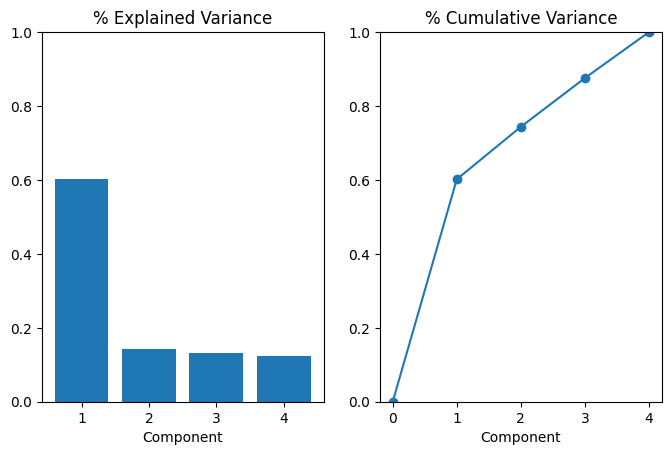

In [25]:
plot_variance(pca)
plt.show()

In [26]:
create_mi_scores(X_pca, y)

PC1    0.81
PC2    0.14
PC4    0.14
PC3    0.12
Name: MI Scores, dtype: float64

In [27]:
feature_df_2

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,1,3,4,3,5,2,0,5,7,5,2003,2003,1,12,13,1,196.0,4,3,2,4,3,1,6,706,1,150,856,1,5,2,5,856,854,1710,1,2,1,3,1,4,8,0,0,1,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,1,8,4,208500
2,0,3,80.0,9600,1,1,3,2,3,24,1,0,2,6,8,1976,1976,1,8,8,2,0.0,3,3,1,4,3,4,5,978,1,284,1262,1,5,2,5,1262,0,1262,0,2,0,3,1,3,6,1,3,1,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,1,8,4,181500
3,5,3,68.0,11250,1,2,3,4,3,5,2,0,5,7,5,2001,2002,1,12,13,1,162.0,4,3,2,4,3,2,6,486,1,434,920,1,5,2,5,920,866,1786,1,2,1,3,1,4,6,1,3,1,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,1,8,4,223500
4,6,3,60.0,9550,1,2,3,0,3,6,2,0,5,7,5,1915,1970,1,13,15,2,0.0,3,3,0,3,4,1,5,216,1,540,756,1,4,2,5,961,756,1717,1,1,0,3,1,4,7,1,4,5,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,1,8,0,140000
5,5,3,84.0,14260,1,2,3,2,3,15,2,0,5,8,5,2000,2000,1,12,13,1,350.0,4,3,2,4,3,3,6,655,1,490,1145,1,5,2,5,1145,1053,2198,1,2,1,4,1,4,9,1,3,1,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,1,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,1,3,4,3,8,2,0,5,6,5,1999,2000,1,12,13,2,0.0,3,3,2,4,3,1,1,0,1,953,953,1,5,2,5,953,694,1647,0,2,1,3,1,3,7,1,3,1,1999.0,2,2,460,3,3,3,0,40,0,0,0,0,1,8,4,175000
1457,0,3,85.0,13175,1,1,3,4,3,14,2,0,2,6,6,1978,1988,1,9,10,3,119.0,3,3,1,4,3,1,5,790,3,589,1542,1,3,2,5,2073,0,2073,1,2,0,3,1,3,7,2,3,1,1978.0,1,2,500,3,3,3,349,0,0,0,0,3,1,8,4,210000
1458,6,3,66.0,9042,1,1,3,4,3,6,2,0,5,7,9,1941,2006,1,5,5,2,0.0,5,4,4,3,4,1,6,275,1,877,1152,1,5,2,5,1188,1152,2340,0,2,0,4,1,4,9,2,4,1,1941.0,2,1,252,3,3,3,0,60,0,0,0,4,3,8,4,266500


In [28]:
X_pca

,PC1,PC2,PC3,PC4
Id,,,,
1,0.654734,-0.268702,-1.008022,-0.246128
2,-0.376345,-0.063134,0.822859,0.326028
3,0.941999,-0.206843,-0.966557,-0.064783
4,-0.097127,0.647328,-0.494942,1.022703
5,2.127062,0.224992,-0.895543,0.582565
...,...,...,...,...
1456,-0.372496,0.613888,0.066302,0.279692
1457,0.791645,1.106346,0.990455,0.072431
1458,1.737927,-0.100794,-1.240392,-2.609588


In [29]:
# Show dataframe sorted by PC3
idx = X_pca["PC1"].sort_values(ascending=False).index 
feature_df_2.loc[idx, ["SalePrice", "Neighborhood", 'OverallQual'] + features]
# feature_df_2.loc[idx, ["SalePrice", "Neighborhood", 'OverallQual'] + features]

,SalePrice,Neighborhood,OverallQual,TotalBsmtSF,GrLivArea,ExterQual,GarageArea
Id,,,,,,,
1299,160000,7,10,6110,5642,5,1418
524,184750,7,10,3138,4676,5,884
692,755000,15,10,2444,4316,5,832
1183,745000,15,10,2396,4476,4,813
582,253293,16,8,2042,2042,5,1390
...,...,...,...,...,...,...,...
376,61000,7,1,683,904,2,0
1324,82500,3,4,420,708,2,0
637,60000,3,2,264,800,2,0


In [30]:
# add PC1 to dataframe
feature_df_2['PC1'] = X_pca['PC1']

In [31]:
score_dataset(feature_df_2)

0.12986291219576257

Score decreased slightly but nothing drastic. Probably have too many variables at the moment plus features such as neighborhood need to be target encoded or one hot encoded.

## Clustering

KMeans - cluster based on features used for principle component analysis

In [32]:
def create_cluster(
    df: pd.DataFrame, features: pd.DataFrame, n_clusters: int = 6
) -> pd.DataFrame:
    X_feats = df[features].copy()
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_feats), columns=X_feats.columns, index=X_feats.index)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    X_scaled.loc[:, "cluster"] = kmeans.fit_predict(X_scaled).astype(int)
    df.loc[:, "cluster"] = X_scaled["cluster"]
    return df

In [33]:
feature_df_2 = create_cluster(feature_df_2, features)

In [34]:
score_dataset(feature_df_2)

0.1300766866023934

The has now come down under 0.13

## Target Encoding

Neighbourhood variable has the most categorical features (25). We can use target encoding to create values for each category that are more reflective of their relationship with the target variable in comparison with OrdinalEncoder which has to be specified manually.

In [35]:
def target_encoding(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:

    # encode of 20% of data to avoid overfitting
    X_encode = df.sample(frac=0.2, random_state=42)
    y_encode = X_encode.pop("SalePrice")

    # split training data
    X_pretrain, y_train = split_x_y_vars(df)

    encoder = MEstimateEncoder(cols=features, m=1, random_state=42)

    encoder.fit(X_encode, y_encode)

    df = encoder.transform(X_pretrain, y_train)
    df['SalePrice'] = y_train
    return df

In [36]:
features_nom = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "CentralAir",
    "GarageType",
    "MiscFeature",
    "SaleType",
    "SaleCondition",
]

In [37]:
# return category features with more than 15 unique values
mask = train_df[features_nom].nunique().sort_values(ascending=False)
target_features = mask[mask > 15].index.tolist()
target_features

['Neighborhood', 'Exterior2nd']

In [38]:
feature_df_3 = target_encoding(feature_df_2, target_features)

In [39]:
score_dataset(feature_df_3)

0.12967228136441908

## One-Hot Encode

Two variables that may explain variance in sale price are SaleType, GarageType and HouseStyle

In [40]:
def one_hot_encode(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    encoder = OneHotEncoder()
    ohe = encoder.fit_transform(df[features])
    ohe_df = pd.DataFrame(ohe.toarray(), columns=encoder.get_feature_names_out(features), index=df.index)
    df_encoded = pd.concat([df, ohe_df], axis=1)
    df_encoded = df_encoded.drop(columns=features)
    return df_encoded, encoder.get_feature_names_out(features)

In [41]:
features = [
    'SaleType',
    'GarageType',
    'HouseStyle'
]

for col in features:
    d = dict(enumerate(train_df[col].cat.categories))
    feature_df_3[col] = feature_df_3[col].map(d)

feature_df_3

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,PC1,cluster,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,1,3,4,3,187384.022546,2,0,2Story,7,5,2003,2003,1,12,217417.050649,1,196.0,4,3,2,4,3,1,6,706,1,150,856,1,5,2,5,856,854,1710,1,2,1,3,1,4,8,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,1,WD,4,0.654734,5,208500
2,0,3,80.0,9600,1,1,3,2,3,179279.937215,1,0,1Story,6,8,1976,1976,1,8,149145.176233,2,0.0,3,3,1,4,3,4,5,978,1,284,1262,1,5,2,5,1262,0,1262,0,2,0,3,1,3,6,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,1,WD,4,-0.376345,0,181500
3,5,3,68.0,11250,1,2,3,4,3,187384.022546,2,0,2Story,7,5,2001,2002,1,12,217417.050649,1,162.0,4,3,2,4,3,2,6,486,1,434,920,1,5,2,5,920,866,1786,1,2,1,3,1,4,6,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,1,WD,4,0.941999,5,223500
4,6,3,60.0,9550,1,2,3,0,3,201357.976455,2,0,2Story,7,5,1915,1970,1,13,169167.962329,2,0.0,3,3,0,3,4,1,5,216,1,540,756,1,4,2,5,961,756,1717,1,1,0,3,1,4,7,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,1,WD,0,-0.097127,1,140000
5,5,3,84.0,14260,1,2,3,2,3,362315.534627,2,0,2Story,8,5,2000,2000,1,12,217417.050649,1,350.0,4,3,2,4,3,3,6,655,1,490,1145,1,5,2,5,1145,1053,2198,1,2,1,4,1,4,9,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,1,WD,4,2.127062,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,1,3,4,3,175946.920776,2,0,2Story,6,5,1999,2000,1,12,217417.050649,2,0.0,3,3,2,4,3,1,1,0,1,953,953,1,5,2,5,953,694,1647,0,2,1,3,1,3,7,1,3,Attchd,1999.0,2,2,460,3,3,3,0,40,0,0,0,0,1,WD,4,-0.372496,1,175000
1457,0,3,85.0,13175,1,1,3,4,3,184061.226455,2,0,1Story,6,6,1978,1988,1,9,168707.703601,3,119.0,3,3,1,4,3,1,5,790,3,589,1542,1,3,2,5,2073,0,2073,1,2,0,3,1,3,7,2,3,Attchd,1978.0,1,2,500,3,3,3,349,0,0,0,0,3,1,WD,4,0.791645,0,210000
1458,6,3,66.0,9042,1,1,3,4,3,201357.976455,2,0,2Story,7,9,1941,2006,1,5,210537.812450,2,0.0,5,4,4,3,4,1,6,275,1,877,1152,1,5,2,5,1188,1152,2340,0,2,0,4,1,4,9,2,4,Attchd,1941.0,2,1,252,3,3,3,0,60,0,0,0,4,3,WD,4,1.737927,5,266500


In [42]:
feature_df_4, encoded_cols = one_hot_encode(feature_df_3, features)

In [43]:
score_dataset(feature_df_4)

0.13085051025364777

Score was worse but likely because many onehot encoded vars are not useful. We will delete the variables that do not have a statistically significant correlation with SalePrice

In [44]:
cols = encoded_cols.tolist() + ['SalePrice']

In [45]:
feat_corr = corr_significance(feature_df_4[cols])
feat_corr.head()

,Variable,correlation,p-value,significant
0,SalePrice,1.0000,0.0,True
1,SaleType_New,0.3575,0.0,True
2,GarageType_Attchd,0.3360,0.0,True
3,HouseStyle_2Story,0.2429,0.0,True
4,GarageType_BuiltIn,0.2354,0.0,True


In [46]:
# cols_to_delete = feat_corr.loc[feat_corr['significant'] == False]['Variable'].tolist()
# feature_df_4 = feature_df_4.drop(columns=cols_to_delete)

In [47]:
mi_scores = create_mi_scores(feature_df_4.drop(columns='SalePrice'), feature_df_4['SalePrice']).tail(20)

In [48]:
feature_df_5 = drop_uninformative_features(feature_df_4, feat_corr, mi_scores)

In [49]:
# re-test data
score_dataset(feature_df_5)

0.1302995260622712

## F3

## General Feature Engineering

In [50]:
def create_room_area(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:, 'RoomAreaRatio'] = df['GrLivArea'] / df['TotRmsAbvGrd']
    return df

In [51]:
def create_garage_area_per_car(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:, 'GarageAreaPerCar'] = df['GarageArea'] / df['GarageCars']
    df.loc[:, 'GarageAreaPerCar'] = df['GarageAreaPerCar'].fillna(0)
    return df

In [52]:
def ratio_land_to_property(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.filter(regex='Area|SF').columns[1:]
    cols = [col for col in cols if 'Total' not in col and 'GrLivArea' not in col] + ['LotFrontage']
    df.loc[:, 'LandToPropertyRatio'] = df['LotArea'] / df[cols].sum(axis=1)
    return df

In [53]:
cols = train_df.filter(regex='Area|SF').columns[1:]
cols

Index(['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'PoolArea'],
      dtype='object')

In [54]:
def create_bath_bedroom_ratio_abv(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:, 'BathBedroomRatioAbv'] = df['FullBath'] / df['BedroomAbvGr']
    df.loc[:, 'BathBedroomRatioAbv'] = df['BathBedroomRatioAbv'].fillna(0)
    df.loc[:, 'BathBedroomRatioAbv'] = df['BathBedroomRatioAbv'].replace([np.inf, -np.inf], 0)
    return df

In [55]:
def feature_engineer_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()

    return (
        data.pipe(create_room_area)
        .pipe(create_garage_area_per_car)
        .pipe(ratio_land_to_property)
        .pipe(create_bath_bedroom_ratio_abv)
        # .pipe(remove_cols)
    )

In [56]:
feature_df_6 = feature_engineer_pipeline(feature_df_5)

In [57]:
corr_df = feature_df_6.iloc[:, -7:]
corr_df['SalePrice'] = feature_df_6['SalePrice']
corr_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice              1.000000
RoomAreaRatio          0.540645
BathBedroomRatioAbv    0.352797
HouseStyle_2Story      0.242880
GarageAreaPerCar       0.158189
LandToPropertyRatio   -0.018087
HouseStyle_1.5Unf     -0.087686
HouseStyle_SFoyer     -0.093090
Name: SalePrice, dtype: float64

In [58]:
corr_sig = corr_significance(corr_df)

In [59]:
mi_scores = create_mi_scores(corr_df.drop(columns='SalePrice'), corr_df['SalePrice'])

In [60]:
feature_df_6 = drop_uninformative_features(feature_df_6, corr_sig, mi_scores)

In [61]:
score_dataset(feature_df_6)

0.13007435581374574

## Drop Variables 

Many variables are likely collinear leading to the dataset to fit to the noise in the dataframe

In [62]:
def check_multicollinearity(df: pd.DataFrame) -> pd.DataFrame:
    """Check for multicollinearity using the variance inflation factor (VIF).

    Args:
        df (pd.DataFrame): pandas dataframe

    Returns:
        pd.DataFrame: pandas dataframe with VIF results
    """
    # Ensure that the dataframe contains only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number])
    
    # Drop the target variable
    numeric_columns = numeric_columns.drop("SalePrice", axis=1)

    # Convert the numeric columns to a numpy array
    num_values = numeric_columns.values

    # Calculate VIF
    vif = pd.DataFrame()
    vif["VIF Factor"] = [
        variance_inflation_factor(num_values, i) for i in range(num_values.shape[1])
    ]
    vif["features"] = numeric_columns.columns
    return vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)

In [63]:
check_multicollinearity(feature_df_6).head(30)

,VIF Factor,features
0,11188.216737,ExterQual
1,4546.643891,GrLivArea
2,2948.653765,PC1
3,2297.336694,TotalBsmtSF
4,2188.936601,GarageArea
5,106.229313,2ndFlrSF
6,79.591977,1stFlrSF
7,34.993181,GarageCars
8,34.732450,TotRmsAbvGrd
9,26.083534,GarageType_None


Lots of these variables are collinear (VIF above 5). Therefore, we can delete some of them to reduce multicollinearity and see if that makes a difference. Bare in mind our validation model is GradientBoostingRegressor is good at dealing with mutlicollinearity so it may not make a difference.

In [64]:
cols_to_delete = [
    '2ndFlrSF',
    '1stFlrSF',
    'GarageCars',
    # 'GarageType_None',
]
feature_df_7 = feature_df_6.drop(columns=cols_to_delete)

In [65]:
check_multicollinearity(feature_df_7).head(30)

,VIF Factor,features
0,11121.087633,ExterQual
1,3208.234654,GrLivArea
2,2925.555399,PC1
3,2296.282310,TotalBsmtSF
4,2005.803228,GarageArea
5,33.346081,TotRmsAbvGrd
6,25.411768,BsmtFinSF1
7,23.107822,BsmtUnfSF
8,19.377700,GarageType_None
9,17.529877,GarageCond


In [66]:
score_dataset(feature_df_7)

0.1302509588579929

Dropping a few features did not make a difference to our dataset as expected. We can now move onto the model building and selection process.

## Feature Pipeline

We can now put together everything above into a data preparation pipeline that follows the SOLID object orientated principles

Data loading classes

In [67]:
class DataLoader(ABC):
    @abstractmethod
    def load_data(self, file_path: str) -> pd.DataFrame:
        pass


class CSVDataLoader(DataLoader):
    def load_data(self, file_path: str) -> pd.DataFrame:
        return pd.read_csv(file_path)


class PickleDataLoader(DataLoader):
    def load_data(self, file_path: str) -> pd.DataFrame:
        return pd.read_pickle(file_path)

In [68]:
class DataSaver(ABC):
    @abstractmethod
    def save_data(self, data: pd.DataFrame, file_path: str):
        pass


class CSVDataSaver(DataSaver):
    def save_data(self, data: pd.DataFrame, file_path: str):
        data.to_csv(file_path, index=False)


class PickleDataSaver(DataSaver):
    def save_data(self, data: pd.DataFrame, file_path: str):
        data.to_pickle(file_path)

Base class used by each class that processes a specific part of the data. By doing this it means we can call the .process() method only once when running the processing pipeline.

In [69]:
class FeatureProcessor(ABC):
    def __init__(self, features: list[str]):
        self._features = features
        
    @abstractmethod
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        pass

In [70]:
class Scaler(FeatureProcessor):
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        scaler = StandardScaler()
        df.loc[:, self._features] = scaler.fit_transform(df[self._features])
        return df

In [71]:
class Imputer(FeatureProcessor):
    def __init__(
        self,
        features: list[str],
        strategy: Literal["mean", "median", "most_frequent"] = "median",
    ):
        self._strategy = strategy
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._features] = df[self._features].fillna(
            df[self._features].agg(self._strategy)
        )
        return df

Class to drop the uninformative variables based on whether a variables correlation with SalePrice is insignificant or it has a 0 mutual information score.

In [72]:
class DropUninformativeFeatures(FeatureProcessor):
    def __init__(
        self,
        insig_corr: list[str],
        zero_mi_scores: list[str],
        features: list[str] | None = None,
    ):
        self._insig_corr = insig_corr
        self._zero_mi_scores = zero_mi_scores
        super().__init__(features)
        
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        cols_to_drop = list(set(self._insig_corr + self._zero_mi_scores))
        return df.drop(columns=cols_to_drop)

Class that creates a principle component based on selected features

In [73]:
class PCAProcessor(FeatureProcessor):
    def __init__(
        self,
        features: list[str],
        n_components: int | None = None,
        standardise: bool = True,
    ):
        self._n_components = n_components
        self._standardise = standardise
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        X = df.loc[:, self._features]
        if self._standardise:
            X = (X - X.mean(axis=0)) / X.std(axis=0)
        pca = PCA(n_components=self._n_components)
        X_pca = pca.fit_transform(X)
        comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        X_pca = pd.DataFrame(X_pca, columns=comp_names, index=X.index)
        df.loc[:, "PC1"] = X_pca["PC1"]
        return df

Class that creates a specified number of clusters for certain variables

In [74]:
class KMeansCluster(FeatureProcessor):
    def __init__(self, features: list[str], n_clusters: int):
        self._n_clusters = n_clusters
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        X_feats = df[self._features].copy()
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_feats), columns=X_feats.columns, index=X_feats.index)
        kmeans = KMeans(n_clusters=self._n_clusters, random_state=42)
        X_scaled.loc[:, "cluster"] = kmeans.fit_predict(X_scaled).astype(int)
        df.loc[:, "cluster"] = X_scaled["cluster"]
        return df

Class that target encodes selected large categorical variables

In [75]:
class TargetEncoder(FeatureProcessor):
    def __init__(self, features: list[str], target: str):
        self._target = target
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        # encode of 20% of data to avoid overfitting
        X_encode = df.sample(frac=0.2, random_state=42)
        target_encode = X_encode.pop(self._target)

        # split training data
        X_pretrain = df.drop(columns=self._target)
        target_train = df[self._target].copy()

        encoder = MEstimateEncoder(cols=self._features, m=1, random_state=42)
        encoder.fit(X_encode, target_encode)

        df = encoder.transform(X_pretrain, target_train)
        df.loc[:, self._target] = target_train
        return df

Class that creates one hot encoded variables from selected features

In [76]:
class DummyEncoder(FeatureProcessor):
    def __init__(self, features: list[str]) -> None:
        super().__init__(features)
        
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        encoder = OneHotEncoder()
        ohe = encoder.fit_transform(df[self._features]).toarray()
        ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(self._features), index=df.index)
        df_encoded = pd.concat([df, ohe_df], axis=1)
        df_encoded = df_encoded.drop(columns=self._features)
        return df_encoded

Class that ordinal encodes variables that have ordered categories

In [77]:
class OrdEncoder(FeatureProcessor):
    def __init__(self, features: list[str] | None = None) -> None:
        super().__init__(features)
        
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        cat_cols = df.select_dtypes(include="category").columns.tolist()
        self._features = [col for col in cat_cols if df[col].cat.ordered]
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        df.loc[:, self._features] = encoder.fit_transform(df[self._features])
        return df

Class that drops selected variables or based on data type

In [78]:
class DropFeatures(FeatureProcessor):
    def __init__(
        self,
        features: list[str] | None = None,
        by_dtype: Literal["number", "category"] | None = None,
    ):
        self._by_dtype = by_dtype
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        if self._by_dtype:
            self._features = df.select_dtypes(include=self._by_dtype).columns.tolist()
        return df.drop(columns=self._features)

Class that creates ratios based on variables within the dataset

In [79]:
class RatioFeature(FeatureProcessor):
    def __init__(self, features: list[str], new_feature_name: str) -> None:
        self._new_feature = new_feature_name
        super().__init__(features)

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df.loc[:, self._new_feature] = (
            (df[self._features[0]] / df[self._features[1:]].sum(axis=1))
            .fillna(0)
            .replace([np.inf, -np.inf], 0)
        )
        return df

Main class that runs the data processing pipeline and allows the user to output to file path

In [80]:
class DataProcessor(FeatureProcessor):
    def __init__(
        self,
        feature_processors: list[FeatureProcessor],
        data_loader: DataLoader,
        data_saver: DataSaver | None = None,
    ) -> None:
        self._feature_processors = feature_processors
        self._data_loader = data_loader
        self._data_saver = data_saver
        self._dataframe = None

    def process(self, file_path: str, output_path: str | None = None) -> pd.DataFrame:
        self._dataframe = self._data_loader.load_data(file_path)
        for processor in self._feature_processors:
            self._dataframe = processor.process(self._dataframe)
        
        if output_path:
            self._data_saver.save_data(self._dataframe, output_path)
            
        return self._dataframe

Select variables for different steps in feature engineering process

In [81]:
def insig_correlation(df: pd.DataFrame) -> list[str]:  
        sig_corr = corr_significance(df)
        return sig_corr.loc[sig_corr["significant"] == False]["Variable"].tolist()
    
def zero_mi_scores(df: pd.DataFrame) -> list[str]:
    mi_scores = create_mi_scores(df.drop(columns="SalePrice"), df["SalePrice"])
    return mi_scores[mi_scores == 0].index.tolist()

In [82]:
num_cols = [
    col
    for col in train_df.select_dtypes(include="number").columns.tolist()
    if col != "SalePrice"
]
insig_corrs = insig_correlation(train_df)
zero_mi_cols = zero_mi_scores(train_df)
pca_cluster_feats = ["TotalBsmtSF", "GrLivArea", "ExterQual", "GarageArea"]
target_encode = ["Neighborhood", "Exterior2nd"]
one_hot_encode = ["SaleType", "GarageType", "HouseStyle"]
feature_1 = ["GrLivArea", "TotRmsAbvGrd"]
feature_2 = ["GarageArea", "GarageCars"]
feature_3 = ["FullBath", "BedroomAbvGr"]
feature_4 = [
    "LotArea",
    "GrLivArea",
    "TotalBsmtSF",
    "GarageArea",
    "MasVnrArea",
    "WoodDeckSF",
    "OpenPorchSF",
]

Initiate feature engineering process

In [83]:
directory = Path().cwd().parent / 'data' / 'final'  

train_output = directory / 'fin_train.pkl'
test_output = directory / 'fin_test.pkl'

In [84]:
inputs = [train_path, test_path]
outputs = [train_output, test_output]

In [85]:
for input_path, output_path in zip(inputs, outputs):
    DataProcessor(
        feature_processors=[
            Imputer(features=num_cols, strategy="median"),
            Scaler(features=num_cols),
            OrdEncoder(),
            DummyEncoder(features=one_hot_encode),
            PCAProcessor(features=pca_cluster_feats),
            KMeansCluster(features=pca_cluster_feats, n_clusters=6),
            TargetEncoder(features=target_encode, target="GrLivArea"),
            RatioFeature(new_feature_name="AreaRoomRatio", features=feature_1),
            RatioFeature(new_feature_name="GarageAreaPerCar", features=feature_2),
            RatioFeature(new_feature_name="BathBedroomRatio", features=feature_3),
            RatioFeature(new_feature_name="LandPropertyRatio", features=feature_4),
            DropUninformativeFeatures(
                insig_corr=insig_corrs, zero_mi_scores=zero_mi_cols
            ),
            DropFeatures(by_dtype="category"),
        ],
        data_loader=PickleDataLoader(),
        data_saver=PickleDataSaver(),
    ).process(file_path=input_path, output_path=output_path)

Both the train and test datasets have now been preprocessed and are ready for model building, evaluation, hyperparameter tuning and prediction.

## Check dataset tranformations have been applied

In [86]:
dir = Path().cwd().parent / 'data' / 'final'
train_df = pd.read_pickle(dir / 'fin_train.pkl').drop(columns=['SalePrice'])
test_df = pd.read_pickle(dir / 'fin_test.pkl')

In [87]:
train_cols = train_df.columns.tolist()
test_cols = test_df.columns.tolist()